# Introducing the `Santorini` environment

## Game Rules
We slightly modified the original [Santorini](https://boardgamegeek.com/boardgame/194655/santorini) boardgame to fit our training regime a little bit better.

### Setup
* 5x5 grid
* 2 players (modified from 2-4 players)
* 2 workers each
* Building pieces
    * 22 First floors
    * 18 Second floors
    * 14 Third floors
    * 18 Domes
* Workers start across from each other (modified from anywhere on the board)
* No special powers (modified from special powers randomly given by cards)

### Each Turn
* Player chooses one of their workers to move to a cell on the board that is:
    * Adjacent to the current position in all eight directions
    * Empty; no other workers standing or no dome covering it
    * No more than one level higher than the current position
* Using that worker at the new current position, the player then choose to build on a cell that is:
    * Adjacent to the current position in all eight directions
    * Building progression is as follows: Empty Floor -> First Floor -> Second Floor -> Third Floor -> Dome
    * A worker cannot build if there are no parts left
    
### Win Condition
The player whose any of their workers stand on the third floor automatically wins.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from santorinigo.environment import Santorini

## Initialization 

Initialize the game with 2 players: `-1` and `1`. `-1` has negative workers `-1` and `-2` whereas `1` has positive workers `1` and `2`. Player `-1` always starts first.

In order to see the human-legible board state, use `print_board` method. This will print out three layers:
1. **Buildings**: the state of buildings, 0 being no building, 1-3 being one- to three-floor buildings, and 4 being a three-floor building with a dome on top
2. **Workers**: negative numbers represent workers belonging to Player`-1` and positive numbers represent workers belonging to Player `1`.
3. **Parts**: the diagonal contains number of pieces left for first, second, third floors and domes respectively (top left to lower right).

In [2]:
env = Santorini(board_dim = (5,5), 
                starting_parts = np.array([0,22,18,14,18]),
                history_len = 3, #tunable hyperparameter
                winning_floor=3)
#print out human-legible board state
env.print_board()

Buildings:
 [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
Workers:
 [[ 0  0 -1  0  0]
 [ 0  0  0  0  0]
 [ 1  0  0  0  2]
 [ 0  0  0  0  0]
 [ 0  0 -2  0  0]]
Parts:
 [[ 0  0  0  0  0]
 [ 0 22  0  0  0]
 [ 0  0 18  0  0]
 [ 0  0  0 14  0]
 [ 0  0  0  0 18]]


## States

`get_state` method returns the for-machine state containing concatenation of the last `history_len` timesteps and one last 5x5 array of -1 or 1 depending on whose turn it is. Each timestep contains the following 5x5 arrays, in order:
1. **Buildings layer**: same as `Buildings` in `print_board`
2. **Worker `-1` layer**: 1 where worker `-1` is and 0 otherwise
3. **Worker `-2` layer**: 1 where worker `-2` is and 0 otherwise
4. **Worker `1` layer**: 1 where worker `1` is and 0 otherwise
5. **Worker `2` layer**: 1 where worker `2` is and 0 otherwise

In [3]:
#number of historical boards recorded
print(env.history_len)
#5 boards for buildings, worker -1, worker -2, worker 1, worker 2
#1 boards for which player turn
print(env.history_len * 5 + 1)
env.get_state().shape

3
16


(16, 5, 5)

## Actions

Each turn a player chooses one of their 2 workers and perform 2 consecutive actions: move and build. The move action moves the selected worker in 8 possible directions. The build action will put a piece on any of the 8 possible directions. If the tile was empty, the worker will build first floor. If it already has first floor, the worker will build second floor and so on. You must move AND build in any turn unless the pieces run out and build action will do nothing.

The directions mimic first-person shooting keyboard layout as follows:

| _ | _ | _ | _ | _ |
|---|---|----|---|---|
| | | q | w | e | | |
| | | a | -1 | d | | |
| | | z | x | c | | |
| _ | _ | _ | _ | _ |

In [4]:
#2 workers * 8 ways to move * 8 ways to build = 128 possible actions
env.action_dim

128

Thus, if you the move `-2` worker north (`w`) and build southeast (`c`), you will have the following board state:

In [5]:
env.step(env.atoi[(-2,'w','c')])
env.print_board()

Buildings:
 [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 1 0]]
Workers:
 [[ 0  0 -1  0  0]
 [ 0  0  0  0  0]
 [ 1  0  0  0  2]
 [ 0  0 -2  0  0]
 [ 0  0  0  0  0]]
Parts:
 [[ 0  0  0  0  0]
 [ 0 21  0  0  0]
 [ 0  0 18  0  0]
 [ 0  0  0 14  0]
 [ 0  0  0  0 18]]


If you move out of the board, for instance moving worker `1` west (`a`) from the current board state, the game will end and player `1` will get -1. Likewise, with illegal builds. You can see all legal moves given the current board state by the `legal_moves` method.

In [6]:
len(env.legal_moves())

62

In [7]:
#available actions
[env.itoa[i] for i in env.legal_moves()][:10]

[(-1, 'w', 'w'),
 (-1, 'w', 'e'),
 (-1, 'w', 'd'),
 (-1, 'w', 'x'),
 (-1, 'w', 'c'),
 (-1, 'e', 'q'),
 (-1, 'e', 'w'),
 (-1, 'e', 'a'),
 (-1, 'e', 'd'),
 (-1, 'e', 'z')]

There are also two useful properties `itoa` and `atoi` that serve as translators between action indice and action tuples.

In [8]:
#env.itoa is a list of all action tuples; convert action indice to action tuples
env.itoa[:10]

[(-1, 'q', 'q'),
 (-1, 'q', 'w'),
 (-1, 'q', 'e'),
 (-1, 'q', 'a'),
 (-1, 'q', 'd'),
 (-1, 'q', 'z'),
 (-1, 'q', 'x'),
 (-1, 'q', 'c'),
 (-1, 'w', 'q'),
 (-1, 'w', 'w')]

In [9]:
#env.atoi is a dictionary with action tuples as keys and action indice as values
#convert action tuples to action indice
i=0
for k,v in env.atoi.items():
    i+=1
    print(k,v)
    if i>10: break

(-1, 'q', 'q') 0
(-1, 'q', 'w') 1
(-1, 'q', 'e') 2
(-1, 'q', 'a') 3
(-1, 'q', 'd') 4
(-1, 'q', 'z') 5
(-1, 'q', 'x') 6
(-1, 'q', 'c') 7
(-1, 'w', 'q') 8
(-1, 'w', 'w') 9
(-1, 'w', 'e') 10


## Human Play

In [10]:
env = Santorini(board_dim = (5,5), 
                starting_parts = np.array([0,22,18,14,18]),
                history_len = 3, #tunable hyperparameter
                winning_floor=3)
#print out human-legible board state
env.print_board()

Buildings:
 [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
Workers:
 [[ 0  0 -1  0  0]
 [ 0  0  0  0  0]
 [ 1  0  0  0  2]
 [ 0  0  0  0  0]
 [ 0  0 -2  0  0]]
Parts:
 [[ 0  0  0  0  0]
 [ 0 22  0  0  0]
 [ 0  0 18  0  0]
 [ 0  0  0 14  0]
 [ 0  0  0  0 18]]


You can keep running the following cells, changing only the `human_key` tuple to play the game.

In [11]:
#change this only
human_key = (-1,'x','w')
human_action = env.atoi[human_key]
print(f'Player {env.current_player} performs {human_key} action (index = {human_action})')

Player -1 performs (-1, 'x', 'w') action (index = 49)


In [12]:
next_state,reward,done,current_player = env.step(human_action)
print(f'Now Player {current_player} turn. Is game done? {done}')
env.print_board()

Now Player 1 turn. Is game done? False
Buildings:
 [[0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
Workers:
 [[ 0  0  0  0  0]
 [ 0  0 -1  0  0]
 [ 1  0  0  0  2]
 [ 0  0  0  0  0]
 [ 0  0 -2  0  0]]
Parts:
 [[ 0  0  0  0  0]
 [ 0 21  0  0  0]
 [ 0  0 18  0  0]
 [ 0  0  0 14  0]
 [ 0  0  0  0 18]]


## Random Play

With the help of `legal_moves` method, we can do random play until one player wins.

In [13]:
env = Santorini(board_dim = (5,5), 
                starting_parts = np.array([0,22,18,14,18]),
                history_len = 3, #tunable hyperparameter
                winning_floor=3)
while True:
    legal_moves = env.legal_moves()
    action = np.random.choice(legal_moves)
    next_state,reward,done,current_player = env.step(action)
    if done: break

In [14]:
print(f'The game ended in {env.turns} turns; {current_player} wins.')
env.print_board()

The game ended in 31 turns; 1 wins.
Buildings:
 [[1 3 1 0 0]
 [0 3 2 0 2]
 [0 4 1 1 2]
 [0 1 0 3 0]
 [1 2 1 1 2]]
Workers:
 [[ 0  0  0  0  0]
 [-1  1  0  0  0]
 [ 0  0  0  0  0]
 [ 0 -2  2  0  0]
 [ 0  0  0  0  0]]
Parts:
 [[ 0  0  0  0  0]
 [ 0  5  0  0  0]
 [ 0  0  9  0  0]
 [ 0  0  0 10  0]
 [ 0  0  0  0 17]]


## Self-Play DQN

We can naively train a DQN agent to play against itself, although there is no clear way of evaluating performance of the agent, unless you play against it.

In [38]:
from santorinigo.memories import *
from santorinigo.networks import *
from santorinigo.agents import *

In [39]:
mem = PrioritizedNStepMemory(int(1e5))
a = DQNAgent(state_size = env.reset().flatten().shape[0], 
             hidden_sizes = [1024,512],
             action_size = env.action_dim, replay_memory = mem,
             double=True, Architecture=DuelingNetwork) 

In [40]:
scores = []
scores_deque = deque(maxlen=100) 
moving_scores = []
from tqdm import tqdm_notebook

for i in tqdm_notebook(range(10000)):
    if (i+1) % 100==0: print(f'Episdoe {i} Moving Average: {np.mean(scores_deque)}')
    state = env.reset().flatten()
    score = 0
    actions = []
    while True:
        #end game when there are no more legal moves
        if len(env.legal_moves()) == 0:
            score = env.turns
            break
        #select action
        action_values = a.act_values(state) 
        if action_values=='random':
            action = np.random.choice(env.legal_moves())
        else:
            for ac in action_values:
                if ac in env.legal_moves():
                    action = ac
                    break
        actions.append(action)

        #env step
        next_state, reward, done, info = env.step(action)   
        
        #agent step
        a.step(state,action,reward,next_state,done)

        
        #go to next state
        state = next_state.flatten()   
        
        #break if done
        if done: 
            score = env.turns
            break
            
    #book keeping
    scores.append(score)
    scores_deque.append(score)
    moving_scores.append(np.mean(scores_deque))

/home/charin/anaconda3/envs/drlnd/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


KeyboardInterrupt: 

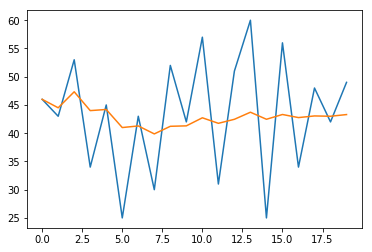

In [41]:
plt.plot(scores)
plt.plot(moving_scores)

In [48]:
env.print_board()

Buildings:
 [[1 3 1 2 2]
 [0 0 2 3 2]
 [2 2 1 1 2]
 [1 3 0 2 0]
 [2 1 4 2 0]]
Workers:
 [[ 0  0  1  0  0]
 [ 0  2  0 -1  0]
 [ 0  0  0  0  0]
 [ 0  0 -2  0  0]
 [ 0  0  0  0  0]]
Parts:
 [[ 0  0  0  0  0]
 [ 0  2  0  0  0]
 [ 0  0  4  0  0]
 [ 0  0  0 10  0]
 [ 0  0  0  0 17]]


In [47]:
env.itoa[a.act(env.get_state().flatten())]

(-2, 'z', 'e')